# 线性回归

在机器学习中大多学的任务通常都与预测(prediction)有关。当我们想预测一个数值时，不会涉及回归问题。比如预测价格（房价、股票）、预测需求（零售销量）、预测电力消耗等。并不是所有的预测相关的问题，都是回归问题，也有分类问题。

线性回归的统计学假设：

- 自变量$\mathbf{x}$和因变量$y$之间的关系是线性的，即$y$可以表示为$\mathbf{x}$中元素的加权和
- 允许观察值有一些噪声，但任何噪声都符合正态分布

In [44]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

样本的数量为$N$，特征长度为$D$，那么

- 输入数据为$X$，是一个$N\times D$的矩阵
- 参数$\mathbf{w}$是一个长度为$D$的向量
- 参数$b$是一个标量
- 输入$\mathbf{y}$是一个长度为$N$的向量，代表每条输入应该真实输出。


模型为：

$$\mathbf{y} = X\cdot \mathbf{w} + b$$

损失函数：
$$L(\mathbf{w},b) = \frac{1}{2N}||X\cdot\mathbf{w} + b -\mathbf{y}||^2$$

损失函数对于$\mathbf{w}$和$b$的梯度为：
$$
\begin{align}
\frac{\partial L}{\partial \mathbf{w}} & = \frac{1}{N}X^T\cdot (X\cdot \mathbf{w} + b - \mathbf{y}) \\
\frac{\partial L}{\partial b} & = \frac{1}{N}\sum(X\cdot \mathbf{w} + b - \mathbf{y})
\end{align}
$$

# 通过随机数来生成数据集

In [48]:
N = 100  # 样本数量
D = 3  # 特征长度
X = torch.rand(N, D) * 10 - 5  # X是[-5,5]之间的均匀采样的随机数
w_true = torch.rand(D)
b_true = torch.rand(1) * 5
y = X.matmul(w_true) + b_true

In [49]:
dataset = torch.utils.data.TensorDataset(X, y)
training_data = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True)

# 定义模型

In [31]:
class LinearRegression(object):
    def __init__(self, num_features):
        self.w = torch.randn(num_features, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, x):
        return x @ self.w + self.b

    def parameters(self):
        return self.w, self.b

    def __call__(self, x):
        return self.forward(x)

# 定义优化目的（损失函数）

In [14]:
# 定义损失函数
def linreg_loss(y_hat, y):
    diff = y_hat - y
    return diff @ (diff.t()) / (2 * y_hat.shape[0])

# 计算梯度

In [15]:
def linreg_grad(X, y, y_hat):
    grad_w = X.t().matmul(y_hat - y) / X.shape[0]
    grad_b = (y_hat - y).mean()
    return grad_w, grad_b


class SGDOptimizer(object):
    def __init__(self, lr):
        self.lr = lr

    def update(self, params, params_grad):
        with torch.no_grad():
            for param, grad in zip(params, params_grad):
                param -= grad * self.lr

# 模型训练

In [18]:
def trainer(data, model, optimizer, epoch=10, plot_loss=True):
    loss_total = []
    for i in range(epoch):
        loss = 0
        for X_batch, y_batch in data:
            y_hat = model(X_batch)
            loss += linreg_loss(y_hat, y_batch)
            grads = linreg_grad(X_batch, y_batch, y_hat)
            optimizer.update(model.parameters(), grads)
        loss = loss / len(training_data)
        loss_total.append(loss)
    if plot_loss:
        plt.plot(loss_total)

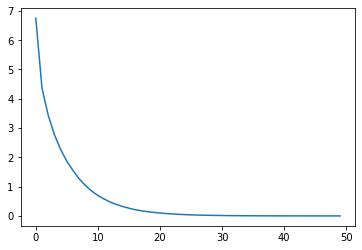

In [28]:
model = LinearRegression(D)
optimizer = SGDOptimizer(lr=0.01)
trainer(training_data, model, optimizer, epoch=50)

# 比较学习出来的参数与实际参数的差距

In [30]:
w, b = model.parameters()
w_error = (w - w_true).mean()
b_error = (b - b_true).mean()
print(f'error of w is {w_error}, error of b is {b_error}')

error of w is -0.00014394521713256836, error of b is -0.024132728576660156


# 使用Pytorch的简洁实现

In [61]:
model = nn.Linear(D, 1) #定义模型
loss = nn.MSELoss() #定义损失
trainer = torch.optim.SGD(model.parameters(), lr=0.03) #定义优化器

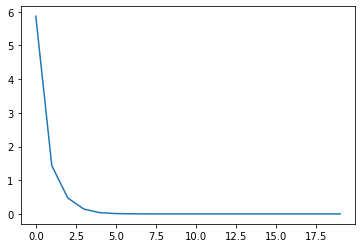

In [62]:
loss_total = []
for i in range(20):
    epoch_loss = 0
    for X_batch, y_batch in training_data:
        y_hat = model(X_batch)
        l = loss(y_hat, y_batch.reshape(y_hat.shape))
        epoch_loss += l.item()
        trainer.zero_grad()
        l.backward() # 代替上面的求梯度的调用
        trainer.step()
    loss_total.append(epoch_loss / len(training_data))
plt.plot(loss_total)

In [65]:
print(w_true, b_true)
print(model.weight.data, model.bias.data)

tensor([0.5663, 0.3489, 0.6513]) tensor([2.7508])
tensor([[0.5663, 0.3489, 0.6513]]) tensor([2.7508])
